![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/b8be43cf89c540bfaf3831f2c8506614).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# %load_ext cudf.pandas
# # # Importación librerías
# import cudf
# import cupy
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, make_scorer, r2_score



In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTrain_carListings.zip')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


In [5]:
# Visualización datos de test
dataTesting.head()

,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


<h1>1. Revisión general de las variables</h1>

<h2>Completitud</h2>

Datos completos al 100%

In [6]:
# # Completitud de los datos
# def analisis_datos(df):
#     columnas = []
#     espacios_blanco = []
#     nan_counts = []
#     porcentaje_faltantes = []

#     for columna in df.columns:
#         espacios_blanco.append(sum(df[columna].apply(lambda x: isinstance(x, str) and x.isspace())))
#         nan_counts.append(df[columna].isna().sum())
#         porcentaje_faltantes.append((df[columna].isna().sum() + espacios_blanco[-1]) / len(df) * 100)  # Calcula el porcentaje de datos faltantes
#         columnas.append(columna)

#     resultados_df = pd.DataFrame({
#         'Columna': columnas,
#         'Espacios en Blanco': espacios_blanco,
#         'NaN': nan_counts,
#         '% Faltantes': porcentaje_faltantes  # Agrega la columna de porcentaje de datos faltantes
#     })

#     print("Resultados:")
#     print(resultados_df)

#     msno.matrix(df)

# analisis_datos(dataTraining)

<h1>2. Descripcion de variables</h1>

<h2>Variables Numericas</h2>

In [7]:
dataTraining.describe()

,Price,Year,Mileage
count,400000.000000,400000.000000,4.000000e+05
mean,21146.919312,2013.198125,5.507296e+04
std,10753.664940,3.292326,4.088102e+04
min,5001.000000,1997.000000,5.000000e+00
25%,13499.000000,2012.000000,2.584100e+04
50%,18450.000000,2014.000000,4.295500e+04
75%,26999.000000,2016.000000,7.743300e+04
max,79999.000000,2018.000000,2.457832e+06


<h2>Variables categoricas</h2>

En total se tienen 3 columnas

<table>
  <tr>
    <th>Columnas</th>
    <th># Valores Unicos</th>
  </tr>
  <tr>
    <td>State</td>
    <td>51</td>
  </tr>
  <tr>
    <td>Make</td>
    <td>38</td>
  </tr>
  <tr>
    <td>Model</td>
    <td>525</td>
  </tr>
</table>

Hay un problema y es una alta cantidad de valores unicos.
una propuesta puede ser armar modelos para cada marca ya que tiene un sentido logico

In [8]:
col_numericas=['Year','Mileage']
col_categoricas=['State','Make','Model']
for col in col_categoricas:
  print(f'valores unicos de {col}:{dataTraining[col].unique()}',f'total variables: {len(dataTraining[col].unique())}', '\n')

valores unicos de State:[' FL' ' OH' ' TX' ' CO' ' ME' ' WA' ' CT' ' CA' ' LA' ' NY' ' PA' ' SC'
 ' ND' ' NC' ' GA' ' AZ' ' TN' ' KY' ' NJ' ' UT' ' IA' ' AL' ' NE' ' IL'
 ' OK' ' MD' ' NV' ' WV' ' MI' ' VA' ' WI' ' MA' ' OR' ' IN' ' NM' ' MO'
 ' HI' ' KS' ' AR' ' MN' ' MS' ' MT' ' AK' ' VT' ' SD' ' NH' ' DE' ' ID'
 ' RI' ' WY' ' DC'] total variables: 51 

valores unicos de Make:['Jeep' 'Chevrolet' 'BMW' 'Cadillac' 'Mercedes-Benz' 'Toyota' 'Buick'
 'Dodge' 'Volkswagen' 'GMC' 'Ford' 'Hyundai' 'Mitsubishi' 'Honda' 'Nissan'
 'Mazda' 'Volvo' 'Kia' 'Subaru' 'Chrysler' 'INFINITI' 'Land' 'Porsche'
 'Lexus' 'MINI' 'Lincoln' 'Audi' 'Ram' 'Mercury' 'Tesla' 'FIAT' 'Acura'
 'Scion' 'Pontiac' 'Jaguar' 'Bentley' 'Suzuki' 'Freightliner'] total variables: 38 

valores unicos de Model:['Wrangler' 'Tahoe4WD' 'X5AWD' 'SRXLuxury' '3' 'C-ClassC300' 'CamryL'
 'TacomaPreRunner' 'LaCrosse4dr' 'ChargerSXT' 'CamryLE' 'Jetta'
 'AcadiaFWD' 'EscapeSE' 'SonataLimited' 'Santa' 'Outlander' 'CruzeSedan'
 'Civic' 'Corol

Cantidad de muestras por año 2014: 17.18%
Cantidad de muestras por año 2017: 11.14%
Cantidad de muestras por año 2004: 0.85%
Cantidad de muestras por año 2015: 17.72%
Cantidad de muestras por año 2016: 13.91%
Cantidad de muestras por año 2013: 8.17%
Cantidad de muestras por año 2008: 3.39%
Cantidad de muestras por año 2012: 7.88%
Cantidad de muestras por año 2003: 0.46%
Cantidad de muestras por año 2011: 5.88%
Cantidad de muestras por año 2010: 4.15%
Cantidad de muestras por año 2005: 1.27%
Cantidad de muestras por año 2006: 1.79%
Cantidad de muestras por año 2007: 2.80%
Cantidad de muestras por año 2009: 2.63%
Cantidad de muestras por año 2000: 0.12%
Cantidad de muestras por año 2001: 0.19%
Cantidad de muestras por año 2002: 0.28%
Cantidad de muestras por año 1998: 0.03%
Cantidad de muestras por año 1999: 0.07%
Cantidad de muestras por año 2018: 0.08%
Cantidad de muestras por año 1997: 0.02%


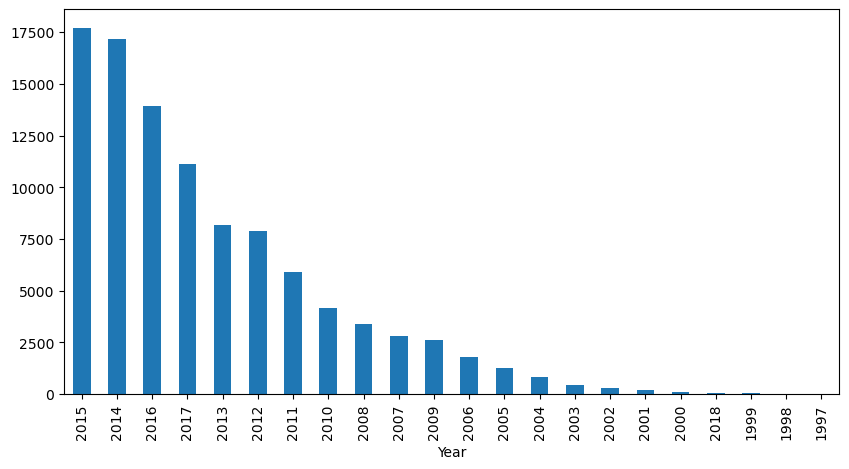

In [9]:
#Cantidad de muestras por Marca
dataTesting['Year'].value_counts().plot(kind='bar',figsize=(10,5))
for val in dataTesting['Year'].unique():
  print(f'Cantidad de muestras por año {val}: {len(dataTesting[dataTesting["Year"]==val])/len(dataTesting)*100:.2f}%')

Debido a la naturaleza de los datos se tienen varias hipoptesis.
- Usar un unico modelo entrenado para predecir para predecir el precio de cada vehiculo basado en el modelo con mejor rendimiento inicial sin hiperparametros definidos
- Usar 1 modelo personalizado por cada item para predecir, segun su marca, modelo, año y kilometraje (si existen todas las variables) para predecir su precio basado en el modelo con mejor rendimiento inicial sin hiperparametros definidos

Cada uno tiene sus retos y transoformaciones
- Agrupacion de variables
- Que modelo usar
- Seleccion de hiperparametros

<h3>Muestras por Marca</h3>

Debido a que la cantidad de muestras por año tiene una tendencia inversamente proporcional a este, se desea saber tambien por marca, cuantas muestras poseemos.

In [10]:
marcas=dataTraining['Make'].unique()
marca_Proporciones=[]
for brand in marcas:
  marca_Proporciones.append([brand,len(dataTraining[dataTraining['Make']==brand])/len(dataTraining)*100])
pd.DataFrame(marca_Proporciones,columns=['Marca','Proporcion']).sort_values(by='Proporcion',ascending=False)


,Marca,Proporcion
10,Ford,15.72475
1,Chevrolet,14.59575
5,Toyota,11.48525
13,Honda,8.29775
0,Jeep,6.09225
9,GMC,5.20850
17,Kia,4.08800
7,Dodge,4.03975
11,Hyundai,3.76425
23,Lexus,3.41600


<h1>3. Modelamiento</h1>

<h2>Procesamiento de variables X y</h2>
se separarán los datos en modelo XTrain y yTrain, ademas se codifican variables categoricas por medio de etiquetas

In [42]:
# Define una función para calcular el RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Define una función para calcular el coeficiente de determinación (R^2)
def r2(y_true, y_pred):
    return r2_score(y_true, y_pred) 


def agrupacion_x_zonas(dataTrain,dataTest):
    state_regions = {
    'FL': 'South', 'OH': 'Midwest', 'TX': 'South', 'CO': 'West', 'ME': 'Northeast', 'WA': 'West', 'CT': 'Northeast', 'CA': 'West', 'LA': 'South', 'NY': 'Northeast', 'PA': 'Northeast', 'SC': 'South', 'ND': 'Midwest', 'NC': 'South',
    'GA': 'South', 'AZ': 'West',  'TN': 'South', 'KY': 'South', 'NJ': 'Northeast', 'UT': 'West', 'IA': 'Midwest', 'AL': 'South', 'NE': 'Midwest', 'IL': 'Midwest', 'OK': 'South', 'MD': 'South', 'NV': 'West', 'WV': 'South',
    'MI': 'Midwest', 'VA': 'South', 'WI': 'Midwest', 'MA': 'Northeast', 'OR': 'West', 'IN': 'Midwest', 'NM': 'West', 'MO': 'Midwest', 'HI': 'West', 'KS': 'Midwest', 'AR': 'South', 'MN': 'Midwest', 'MS': 'South', 'MT': 'West',
    'AK': 'West', 'VT': 'Northeast', 'SD': 'Midwest', 'NH': 'Northeast', 'DE': 'South', 'ID': 'West', 'RI': 'Northeast', 'WY': 'West', 'DC': 'South'
    }
    dataTrain['State'] = dataTrain['State'].str.strip()
    dataTrain['Region'] = dataTrain['State'].map(state_regions)
    dataTrain = dataTrain.drop(columns="State")

    dataTest['State'] = dataTest['State'].str.strip()
    dataTest['Region'] = dataTest['State'].map(state_regions)
    dataTest = dataTest.drop(columns="State")
    return dataTrain, dataTest

def label_encoder(dataTrain,dataTest,columnas_categoricas):
    np.random.seed(1)
    label_encoders = {}
    #refactorizacion de columnas
    for col in columnas_categoricas:
        label_encoders[col] = LabelEncoder()
        dataTrain[col] = label_encoders[col].fit_transform(dataTrain[col])
        dataTest[col] = label_encoders[col].transform(dataTest[col])
    return dataTrain,dataTest

def generadorDummies(dataTrain,dataTest,columnas_categoricas):
    np.random.seed(1)
    # Codificación de variables categóricas
    dataTrain = pd.get_dummies(dataTrain, columns=columnas_categoricas).astype(int)
    dataTrain = dataTrain.drop(columns=["Region_Northeast", "Make_Acura","Model_Yaris4dr"])
    dataTest = pd.get_dummies(dataTest, columns=columnas_categoricas).astype(int)
    dataTest = dataTest.drop(columns=["Region_Northeast", "Make_Acura","Model_Yaris4dr"])
    dataTest = dataTest.reindex(columns=dataTrain.columns, fill_value=0)
    return dataTrain,dataTest

def normalizacion_Standard(dataTrain,dataTest):
    np.random.seed(1)
    scaler = StandardScaler()
    dataTrain[['Mileage', 'Year']] = scaler.fit_transform(dataTrain[['Mileage', 'Year']])
    dataTest[['Mileage', 'Year']] = scaler.transform(dataTest[['Mileage', 'Year']])
    return dataTrain,dataTest

def normalizacion_MaxMin(dataTrain,dataTest):
    np.random.seed(1)
    scaler = StandardScaler()
    dataTrain[['Mileage', 'Year']] = scaler.fit_transform(dataTrain[['Mileage', 'Year']])
    dataTest[['Mileage', 'Year']] = scaler.transform(dataTest[['Mileage', 'Year']])
    return dataTrain,dataTest

def clustering_PCA(dataTrain,dataTest):
    kmeans = KMeans(n_clusters=5, random_state=42)
    dataTrain['Cluster'] = kmeans.fit_predict(dataTrain[['Year', 'Mileage']])
    dataTest['Cluster'] = kmeans.predict(dataTest[['Year', 'Mileage']])
    dataTrain = pd.get_dummies(dataTrain, columns=['Cluster'])
    dataTest = pd.get_dummies(dataTest, columns=['Cluster'])
    pca = PCA(n_components=0.99)
    dataTrain = pca.fit_transform(dataTrain.drop(['Price'], axis=1))
    dataTest = pca.transform(dataTest.drop(['Price'], axis=1))
    return dataTrain,dataTest
    

def clustering_PLS(dataTrain, dataTest):
    kmeans = KMeans(n_clusters=5, random_state=42)
    dataTrain['Cluster'] = kmeans.fit_predict(dataTrain[['Year', 'Mileage']])
    dataTest['Cluster'] = kmeans.predict(dataTest[['Year', 'Mileage']])
    dataTrain = pd.get_dummies(dataTrain, columns=['Cluster'])
    dataTest = pd.get_dummies(dataTest, columns=['Cluster'])
    X_train = dataTrain.drop(['Price'], axis=1)
    y_train = dataTrain['Price']
    pls = PLSRegression(n_components=8)  # Definir el número de componentes latentes
    pls.fit(X_train, y_train)
    dataTrain = pls.transform(dataTrain.drop(['Price'], axis=1))
    dataTest = pls.transform(dataTest.drop(['Price'], axis=1))
    return dataTrain, dataTest

def evaluacion_primaria(X,y):
    resultados={}

    models={
        'linear':LinearRegression(),
        # 'decision_tree':DecisionTreeRegressor(random_state=1),
        # 'random_forest':RandomForestRegressor(random_state=1),
        # 'gradient_boosting':GradientBoostingRegressor(random_state=1),
        'XGBoost':XGBRegressor(n_estimators=400, learning_rate=0.1,  max_depth=7, subsample= 1, um_parallel_tree=1, verbosity=1, random_state=1,tree_method="hist",device = "cuda"),
        # 'adaboost+DecisionTree':AdaBoostRegressor(random_state=1,estimator=DecisionTreeRegressor(random_state=1)),
        # 'neural_network':MLPRegressor(random_state=1, max_iter=10000, hidden_layer_sizes=(7, 5),solver='adam', alpha=1e-5)
    }
    for model,function in models.items():
        # if model=='XGBoost':
        #     X=cudf.from_pandas(X)
        #     y=cudf.from_pandas(y)
        scores_r2 = cross_val_score(function, X, y, cv=5, scoring=make_scorer(r2))
        scores_rmse = cross_val_score(function, X, y, cv=5, scoring=make_scorer(rmse))
        resultados[model]=scores_rmse.mean()
        print(f'Resultado {model}: r2={scores_r2.mean()} rmse:{scores_rmse.mean()}')

    plt.bar(resultados.keys(), resultados.values())
    plt.xlabel('Modelo')
    plt.ylabel('RMSE')
    plt.grid()
    plt.show() 


def preprocess_regresion(dataTrain,dataTest):
    dataTrain,dataTest=agrupacion_x_zonas(dataTrain,dataTest)
    # dataTrain,dataTest=label_encoder(dataTrain,dataTest,['Region','Make','Model'])
    dataTrain,dataTest=generadorDummies(dataTrain,dataTest,['Region','Make','Model'])
    dataTrain,dataTest=normalizacion_Standard(dataTrain,dataTest)
    dataTrain,dataTest=clustering_PLS(dataTrain,dataTest)
    return dataTrain,dataTest



<h2>Preprocesamiento y evaluacion en primera escala</h2>

Resultado linear: r2=0.8312339872807899 rmse:4417.654400396628
Resultado XGBoost: r2=0.890846463711372 rmse:3552.6831130083547


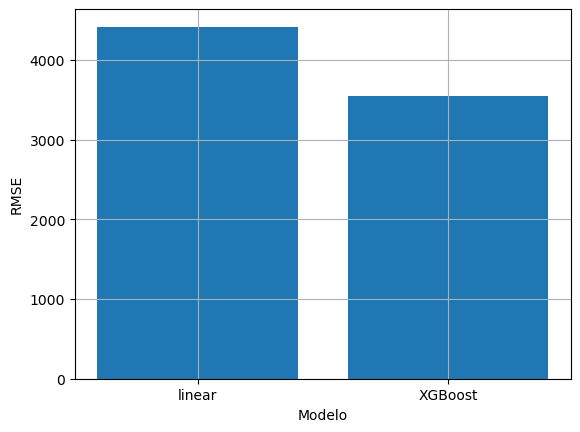

In [43]:
dataTrainingCopy = dataTraining.copy()
dataTestingCopy = dataTesting.copy()

dataTrainingCopy,dataTestingCopy=preprocess_regresion(dataTrainingCopy, dataTestingCopy)

X=dataTrainingCopy
y=dataTraining[['Price']].values.ravel()
evaluacion_primaria(X,y)

<h3>Calibrador del modelo</h3>

En este caso sabemos que XGBoost nos entrega el mejor resultado

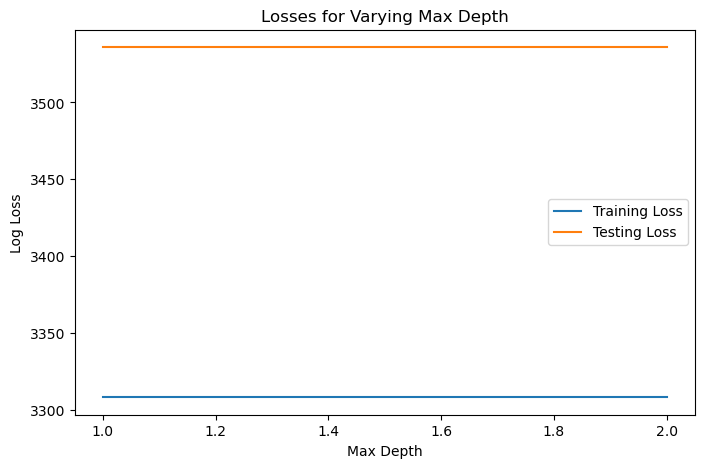

CPU times: total: 33.9 s
Wall time: 6.63 s


In [18]:
%%time
#Primer modelo de regresión

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary max_depth hyperparameter
max_depths = list(range(1,3,1))
train_losses_depth = []
test_losses_depth = []
count=0
for max_depth in max_depths:
    count+=1
    print(f'{int((count/len(max_depths))*100)} %', end="\r")
    rf = XGBRegressor(n_estimators=380,learning_rate=0.1,  max_depth=7, subsample= 1.0, verbosity=1, random_state=1,tree_method="hist",device = "cuda")
    rf.fit(X_train, y_train)
    
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)
    
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    train_losses_depth.append(train_rmse)
    test_losses_depth.append(test_rmse)

# Plot the training and testing losses for max_depth
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

ax1.plot(max_depths, train_losses_depth, label="Training Loss")
ax1.plot(max_depths, test_losses_depth, label="Testing Loss")
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Log Loss")
ax1.legend()
ax1.set_title("Losses for Varying Max Depth")

plt.show()

<h2>Prediccion con XGBoost basado en un Marca</h2>

Debido a que hay amplia informacion, se hizo una segregacion de la data a modelar basados en marca, modelo, estado y kilometraje, se entrena un modelo XGBoost y uno a uno se muestran los resultados. Para el ejemplo dado, se ve un resultado 

In [74]:
def TEST_XGBoost_marca(df):
    modelo={
        'modelo_1':0,
        'modelo_2':0,
        'modelo_3':0,
        'modelo_4':0
    }

    #____________ORDENA AGRUPA VARIABLES EN DATASET____________
    pricing_results=[]
    RMSE=[]

    for row in df.iterrows():
#Encuentro datos similares
        similares=df[
            (df.Make==row[1].Make)&
            (df.Year.between(row[1]['Year']-1,row[1]['Year']))&
            (df.Region==row[1].Region)&
            (df.Mileage.between(row[1].Mileage*0.9,row[1].Mileage*1.1))   
        ].sort_values(by='Mileage')
        if(similares.shape[0]==0):
            similares=df[
            (df.Make==row[1].Make)&
            (df.Year.between(row[1]['Year']-3,row[1]['Year']))&
            (df.Region==row[1].Region)&
            (df.Mileage.between(row[1].Mileage*0.8,row[1].Mileage*1.2))   
            ].sort_values(by='Mileage')
            if(similares.shape[0]==0):
                similares=df[
                    (df.Make==row[1].Make)&
                    (df.Region==row[1].Region)&
                    (df.Mileage.between(row[1].Mileage*0.7,row[1].Mileage*1.3))
                ].sort_values(by='Mileage')
                if(similares.shape[0]==0):
                    similares=df[(df.Make==row[1].Make)].sort_values(by='Mileage')
                    modelo['modelo_4']+=1
                else:    
                    modelo['modelo_3']+=1
            else:
                modelo['modelo_2']+=1
        else:
            modelo['modelo_1']+=1


    #Modelo
        X_similares=similares.drop(['Price'], axis=1)
        y_similares=similares[['Price']].values.ravel()

        #MODELO XGBOOST
        model = XGBRegressor(
            n_estimators=400, 
            learning_rate=0.5,  
            max_depth=7, 
            subsample= 0.8, 
            num_parallel_tree=3, 
            verbosity=2, 
            random_state=1,
            tree_method="hist",
            device = "cuda")

        model.fit(X_similares, y_similares)
        #Predigo con modelo
        pred=model.predict([row[1].drop(['Price'])])
        pricing_results.append(np.round(pred[0]).astype(int))
        RMSE.append(np.sqrt(mean_squared_error([row[1].Price], [pred[0]])))
        print(f'trabajando: {round((row[0]/df.shape[0])*100,2)}% , Modelos: {modelo}, RMSE:{np.mean(RMSE)}',end='\r')

    return pricing_results,RMSE



def XGBoost_marca(dataTrain,dataTest):
    modelo={
        'modelo_1':0,
        'modelo_2':0,
        'modelo_3':0,
        'modelo_4':0
    }

    #____________ORDENA AGRUPA VARIABLES EN DATASET____________
    pricing_results=[]

    for row in dataTest.iterrows():
#Encuentro datos similares
        similares=dataTrain[
            (dataTrain.Make==row[1].Make)&
            (dataTrain.Year.between(row[1]['Year']-1,row[1]['Year']))&
            (dataTrain.Region==row[1].Region)&
            (dataTrain.Mileage.between(row[1].Mileage*0.9,row[1].Mileage*1.1))   
        ].sort_values(by='Mileage')
        if(similares.shape[0]==0):
            similares=dataTrain[
            (dataTrain.Make==row[1].Make)&
            (dataTrain.Year.between(row[1]['Year']-3,row[1]['Year']))&
            (dataTrain.Region==row[1].Region)&
            (dataTrain.Mileage.between(row[1].Mileage*0.8,row[1].Mileage*1.2))   
            ].sort_values(by='Mileage')
            if(similares.shape[0]==0):
                similares=dataTrain[
                    (dataTrain.Make==row[1].Make)&
                    (dataTrain.Region==row[1].Region)&
                    (dataTrain.Mileage.between(row[1].Mileage*0.7,row[1].Mileage*1.3))
                ].sort_values(by='Mileage')
                if(similares.shape[0]==0):
                    similares=dataTrain[(dataTrain.Make==row[1].Make)].sort_values(by='Mileage')
                    modelo['modelo_4']+=1
                else:    
                    modelo['modelo_3']+=1
            else:
                modelo['modelo_2']+=1
        else:
            modelo['modelo_1']+=1

    #Modelo
        dataTrainingCopy,dataTestingCopy=preprocess_regresion(dataTrainingCopy, dataTestingCopy)
        X_similares=similares.drop(['Price'], axis=1)
        y_similares=similares[['Price']].values.ravel()

        #MODELO XGBOOST
        model = XGBRegressor(
            n_estimators=100, 
            learning_rate=0.5,  
            max_depth=7, 
            subsample= 0.8, 
            num_parallel_tree=3, 
            verbosity=2, 
            random_state=1,
            tree_method="hist",
            device = "cuda")

        model.fit(X_similares, y_similares)
        #Predigo con modelo
        pred=model.predict([row[1]])
        pricing_results.append(np.round(pred[0]).astype(int))
        print(f'trabajando: {round((row[0]/dataTest.shape[0])*100,2)}% , Modelos: {modelo}',end='\r')

    return pricing_results


<h3>playground con datos de dataTraining</h3>

In [75]:
pricing_results=XGBoost_marca(dataTrainingCopy,dataTestingCopy)

dataTestingCopy['Price']=pricing_results
y_pred = pd.DataFrame(dataTestingCopy, index=dataTestingCopy.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')

print('>_> (100% papa)')

KeyboardInterrupt: 

<h3>Calibrador de playground</h3>

In [55]:
sample=dataTrainingCopy.iloc[1]
print(sample)

query=dataTrainingCopy[
    (dataTrainingCopy['Make']==sample['Make'])&
    (dataTrainingCopy['Mileage'].between(sample['Mileage']*0.9,sample['Mileage']*1.1))&
    (dataTrainingCopy['Year'].between(sample['Year']-1,sample['Year']))&
    (dataTrainingCopy['Region']==sample['Region'])
].sort_values(by='Mileage')

X_similares=query.drop(['Price'], axis=1)
y_similares=query[['Price']].values.ravel()


model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.1,  
    max_depth=7, 
    subsample= 0.8, 
    num_parallel_tree=3, 
    verbosity=2, 
    seed=1,
    tree_method="hist",
    device = "cuda")
model.fit(X_similares, y_similares)
pred=model.predict([sample.drop(['Price'])])

print(f'Mean:',query['Price'].mean())
print(f'Prediccion:',pred[0].astype(int))
query.describe()

Price      37895.00000
Year        2015.00000
Mileage        0.00837
Make           6.00000
Model        448.00000
Region         0.00000
Name: 1, dtype: float64
Mean: 24527.314024390245
Prediccion: 37908


,Price,Year,Mileage,Make,Model,Region
count,328.000000,328.000000,328.000000,328.0,328.000000,328.0
mean,24527.314024,2014.786585,0.008352,6.0,289.545732,0.0
std,9398.540350,0.410344,0.000489,0.0,127.986373,0.0
min,9981.000000,2014.000000,0.007536,6.0,82.000000,0.0
25%,16990.750000,2015.000000,0.007933,6.0,158.000000,0.0
50%,20242.500000,2015.000000,0.008315,6.0,292.000000,0.0
75%,30405.500000,2015.000000,0.008772,6.0,417.000000,0.0
max,54509.000000,2015.000000,0.009199,6.0,448.000000,0.0


<h3>Encontrando los mejores hiperparametros</h3>

In [ ]:
# Predicción del conjunto de test - acá se genera un número aleatorio como ejemplo
np.random.seed(42)
y_pred = pd.DataFrame(np.random.rand(dataTesting.shape[0]) * 75000 + 5000, index=dataTesting.index, columns=['Price'])

              Price
ID                 
0      33090.508914
1      76303.572981
2      59899.545636
3      49899.386315
4      16701.398033
...             ...
99995  64422.862300
99996  63443.967139
99997  55584.005547
99998  42458.543350
99999  34243.136396

[100000 rows x 1 columns]


<h3>Prediccion con XGBoost basado en un todo el modelo</h3>

In [30]:
# Guardar predicciones en formato exigido en la competencia de kaggle

clf = XGBRegressor(n_estimators=400,learning_rate=0.1,  max_depth=7, subsample= 0.8, num_parallel_tree=3, verbosity=2, random_state=1,tree_method="hist",device = "cuda"
)
clf.fit(X,y)
pred=clf.predict(dataTestingCopy)
valor_final=np.round(pred).astype(int)
y_pred = pd.DataFrame(valor_final, index=dataTesting.index, columns=['Price'])
y_pred.to_csv('test_submission.csv', index_label='ID')
y_pred.head()


,Price
ID,
0,22171
1,37831
2,24460
3,8061
4,30208
